In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
from scipy.optimize import minimize
from scipy import stats


In [27]:
NSIDE = 128
NPIXEL = hp.pixelfunc.nside2npix(NSIDE)
Ncount = 100000 # 3yr event in bin 0 and 1

analy_galaxymap_path = '../data/ancil/analy_galaxymap.fits'
analy_galaxymap = hp.fitsfunc.read_map(analy_galaxymap_path, verbose=False)
overdensity_g = analy_galaxymap / np.mean(analy_galaxymap) - 1. 
analy_CL = hp.sphtfunc.anafast(overdensity_g)

In [28]:
def w_std(N_re):
    w_cross = np.zeros((N_re, 3 * NSIDE))
    for iteration in np.arange(N_re):
        total_counts = np.random.poisson(Ncount)
        countsmap = np.random.poisson(total_counts / float(NPIXEL), NPIXEL)
        overdensity_nu = countsmap / np.mean(countsmap) - 1. 
        w_cross[iteration] = hp.sphtfunc.anafast(overdensity_g, overdensity_nu)
    return np.mean(w_cross, axis=0), np.std(w_cross, axis=0)

w_mean, w_model_std = w_std(100)


In [29]:
def log_likelihood(f, w_data): 
    w_model_mean = f * analy_CL
    lnL_le = - (w_data - w_model_mean) ** 2 / (2 * w_model_std ** 2)
    return np.sum(lnL_le) 


In [30]:
def minimize__lnL(w_data):
    nll = lambda *args: -log_likelihood(*args)
    initial = 0.1 
    soln = minimize(nll, initial, args=(w_data), bounds=[(-1, 1)]) 
    return soln.x, (log_likelihood(soln.x, w_data) - log_likelihood(0., w_data)) * 2


In [31]:
def TS_distribution(N_test):
    TS = np.zeros(N_test)
    for i in range(N_test):
        total_counts = np.random.poisson(Ncount)
        countsmap = np.random.poisson(total_counts / float(NPIXEL), NPIXEL)
        overdensity_nu = countsmap / np.mean(countsmap) - 1. 
        #hp.mollview(overdensity_nu)
        w_data = hp.sphtfunc.anafast(overdensity_g, overdensity_nu)
        TS[i] = (minimize__lnL(w_data))[-1]
        
    return TS

In [32]:
N_test = 10000
TS_atm = TS_distribution(N_test)


(0.0001, 1.1)

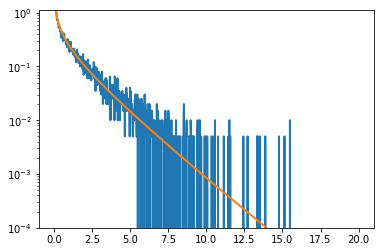

In [47]:
TS_bins = np.linspace(0, 20, 1001)
TS_bins_c = (TS_bins[0:-1] + TS_bins[1:]) / 2.
dTS_bins = np.mean(TS_bins[1:] - TS_bins[0:-1])
p_atm = np.histogram(TS_atm, TS_bins)[0] / float(N_test) / dTS_bins
plt.plot(TS_bins_c, p_atm, lw=2, label='atm')
plt.plot(TS_bins_c, stats.chi2.pdf(TS_bins_c, 1)   , lw=2, label='chi2, dof=1')
plt.yscale('log')
plt.ylim(1e-4, 1.1)



